# Technical setup

Today's class and homework will be based on `torchdiffeq`. 

You should be able to install this by updating the Conda configuration:

```shell
git pull 
conda env update --file environment.yml
conda activate MLBD-MRes
```

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchdiffeq import odeint

# Neural Ordinary Differential Equations

The starting point for this classwork is the NeuroIPS 2018 'best paper', 

https://arxiv.org/abs/1806.07366

## Neural Ordinary Differential Equations
*Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, David Duvenaud*

> We introduce a new family of deep neural network models. Instead of specifying a discrete sequence of hidden layers, we parameterize the derivative of the hidden state using a neural network. The output of the network is computed using a black-box differential equation solver. These continuous-depth models have constant memory cost, adapt their evaluation strategy to each input, and can explicitly trade numerical precision for speed. We demonstrate these properties in continuous-depth residual networks and continuous-time latent variable models. We also construct continuous normalizing flows, a generative model that can train by maximum likelihood, without partitioning or ordering the data dimensions. For training, we show how to scalably backpropagate through any ODE solver, without access to its internal operations. This allows end-to-end training of ODEs within larger models.

This notebook is based in the `ode_demo.py` example distributed with `torchdiffeq` (https://github.com/rtqichen/torchdiffeq/tree/master/examples), including some bits from Alexandr Honchar's blogpost https://towardsdatascience.com/neural-odes-breakdown-of-another-deep-learning-breakthrough-3e78c7213795. 



## Reading

https://jontysinai.github.io/jekyll/update/2019/01/18/understanding-neural-odes.html - Jonty Sinai's fairly introductory decomposition of the paper

https://towardsdatascience.com/neural-odes-breakdown-of-another-deep-learning-breakthrough-3e78c7213795 - Alexandr Honchar's description, based on the same `torchdiffeq` example we use here.

https://www.depthfirstlearning.com/2019/NeuralODEs - Luca Venturi's more rigorous mathematical introduction; with about 5 hours of self-study material.

The Torchdyn project https://github.com/DiffEqML/torchdyn , is an alternative library that builds on `torchdiffeq` to offer a higher level / more abstract interface. There are a number of high quality tutorials https://github.com/DiffEqML/torchdyn/tree/master/tutorials that demonstrate the more advanced application of neural ODEs. 

In [4]:
batch_time = 10
batch_size = 20
data_size = 1000
test_freq = 10

niters = 80

viz = True

In [7]:
#  From https://scipython.com/blog/the-lorenz-attractor/
# Lorenz parameters and initial conditions.
#sigma, beta, rho = 10, 2.667, 28
sigma, beta, rho = 10, 8/3, 15
true_y0 = torch.tensor([[0, 1, 1.05]]).to(device)     # starting vector for ODE
t = torch.linspace(0., 25., data_size).to(device) # time over which ODE is integrated

class Lambda(nn.Module):
    def forward(self, t, y):
        """The Lorenz equations."""
        u, v, w = y[0]
        up = -sigma*(u - v)
        vp = rho*u - v - u*w
        wp = -beta*w + u*v
        return torch.tensor([[up, vp, wp]]).to(device)

In [8]:
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')
true_y

tensor([[[ 0.0000,  1.0000,  1.0500]],

        [[ 0.2217,  1.0153,  0.9850]],

        [[ 0.4060,  1.1000,  0.9296]],

        ...,

        [[-6.1085, -6.1072, 14.0008]],

        [[-6.1082, -6.1072, 14.0000]],

        [[-6.1080, -6.1073, 13.9993]]])

In [9]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

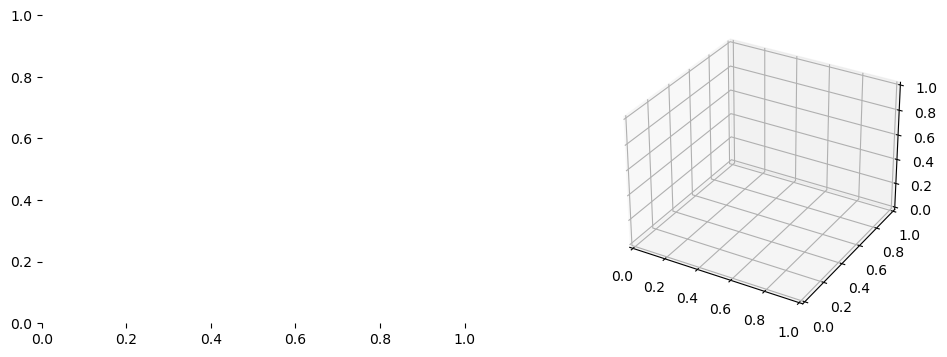

In [11]:
if viz:
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(121, frameon=False)
    ax_phase = fig.add_subplot(122, projection='3d')
    plt.show(block=False)

In [13]:
def visualize(true_y, pred_y, odefunc, itr):

    if viz:

        fig = plt.figure(figsize=(12, 4), facecolor='white')
        ax_traj = fig.add_subplot(121, frameon=False)
        ax_phase = fig.add_subplot(122, projection='3d')

        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y,z')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,0], 'k-', label='true x')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,1], 'm-', label='true y')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,2], 'b-', label='true z')
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,0], 'k--', label='predicted x')
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,1], 'm--', label='predicted y')
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,2], 'b--', label='predicted z')
        ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        #ax_traj.set_ylim(-2, 2)
        ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.plot(true_y.cpu().numpy()[:,:,0], true_y.cpu().numpy()[:,:,1], true_y.cpu().numpy()[:,:,2], 'g--', label="True")

        s=10
        n=len(t)
        line_segments = [(pred_y.cpu().numpy()[:,:,0][i:i+s+1], pred_y.cpu().numpy()[:,:,1][i:i+s+1], pred_y.cpu().numpy()[:,:,2][i:i+s+1]) for i in range(0,n-s,s)]
        segment_colours = [plt.cm.winter(i/n) for i in range(0,n-s,s)]
        #lines = Line3DCollection(line_segments, colors = segment_colours, label='Predicted')
        #ax_phase.add_collection(lines)
        for i, line in enumerate(line_segments):
            ax_phase.plot(line[0], line[1], line[2], color = segment_colours[i])

        #ax_phase.plot(pred_x, pred_y, pred_z, 'b--')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.set_zlabel('z')

        fig.tight_layout()
        plt.draw()
        plt.pause(0.001)


In [14]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(3, 50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.Linear(50, 3),
        ).to(device)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)



In [15]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


Iter 0010 | Total Loss 9.681809


AttributeError: 'AxesSubplot' object has no attribute 'set_zlabel'

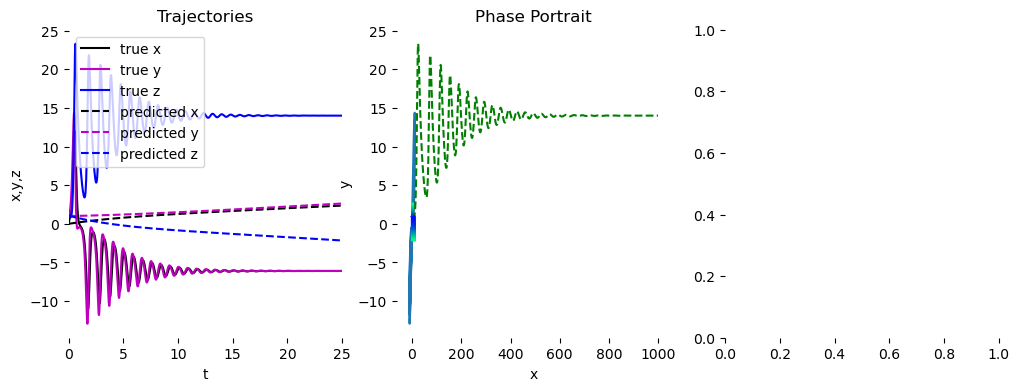

In [16]:
def main():
    ii = 0

    func = ODEFunc().to(device)
    
    optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
    end = time.time()

    time_meter = RunningAverageMeter(0.97)
    
    loss_meter = RunningAverageMeter(0.97)

    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        pred_y = odeint(func, batch_y0, batch_t).to(device)
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        time_meter.update(time.time() - end)
        loss_meter.update(loss.item())

        if itr % test_freq == 0:
            with torch.no_grad():
                pred_y = odeint(func, true_y0, t)
                loss = torch.mean(torch.abs(pred_y - true_y))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                visualize(true_y, pred_y, func, ii)
                ii += 1

        end = time.time()
    
    return func

finalfunc=main()
# Nb: plots are being saved to a png/niter subfolder, for if you want to include them in your lab report.

In [15]:
# Parameters for our ODE
true_A

tensor([[-0.1000,  2.0000],
        [-2.0000, -0.1000]])

In [16]:
finalfunc.parameters

<bound method Module.parameters of ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=2, bias=True)
  )
)>

# Task 1

Do the reading. 
Play with the above code! 

You may need to refresh your knowledge of ODEs. 

Summarise how the Neural Network ODE works. 
How does the above model structure compare to the 'direct' neural networks that you've been working with? 

# Task 2 

Replace the cubic / hard edged spiral above with a smooth spiral. This requires changing the 'Lambda' function, as shown below. 

Does the ODE neural network still fit? 
Hint: to improve it you might need to look at the forward pass of the neural network

In [ ]:
class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y, true_A) # smooth spiral

# Task 3

The equations of motion of this ODE have been chosen to make a nice spiral. Can you write out the differential equations? The work is done by the `torch.mm` (matrix multiply) function. 

Alterantely, we can look at sampling from the space of all possible first order differential equations with two components. One way to do this is to sample the coefficients for this matrix multiplication. Try this, and see what sort of phase portraits and vector fields are found.

In [ ]:
true_A = torch.randn(2, 2)/4. # Random initial conditions for the ODE

# Task 4

Investigate noise corruption of the data. 
(All experimental data contains noise.)

This will require something like the following, in the subroutine where the training data (the solved ODE) is generated.

```python
true_y = true_y + 0.01*torch.randn(data_size,2)
```

How robust is the neural ODE to noise corrupted data?

# Task 5

Build a neural-network (but not an ODE neural network!) to try and predict time series data. Trial it on the same ODE synthetic data as in this system. 

This could be a simple (direct) multilayer perceptron, or the 1D CNN from Miniproject 4.